In [3]:
%ls ..

input/  lib/  working/


In [4]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16625, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 16625 (delta 58), reused 66 (delta 30), pack-reused 16522
Receiving objects: 100% (16625/16625), 15.16 MiB | 34.35 MiB/s, done.
Resolving deltas: 100% (11415/11415), done.


In [5]:
!apt-get update
!apt install -y python3.8

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]    
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [1616 B]       
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1562 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:7 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Err:2 http://packages.cloud.google.com/apt gcsfuse-focal InRelease             
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY C0BA5CE6DC6315A3
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Err:3 https://packages.cloud.google.com/apt cloud-sdk InRelease     
  The following signatures couldn't be verified bec

In [7]:
!pip install virtualenv

!virtualenv venv -p $(which python3.8)

created virtual environment CPython3.8.10.final.0-64 in 789ms
  creator CPython3Posix(dest=/kaggle/working/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==22.2.2, setuptools==65.3.0, wheel==0.37.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [8]:
!/kaggle/working/venv/bin/pip install  -qr ./yolov5/requirements.txt 


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: /kaggle/working/venv/bin/python -m pip install --upgrade pip


### Data preparation
---

In [9]:
import os
import shutil
import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path

In [12]:
!mkdir ./new_dataset

In [19]:
%ls ./yolov5/

Argoverse.yaml        ImageNet1000.yaml  coco.yaml         scripts/
GlobalWheat2020.yaml  Objects365.yaml    coco128-seg.yaml  xView.yaml
ImageNet.yaml         SKU-110K.yaml      coco128.yaml
ImageNet10.yaml       VOC.yaml           hyps/
ImageNet100.yaml      VisDrone.yaml      images/


In [20]:
!cp -r ../input/militaryaircraftdetectiondataset ./new_dataset

In [25]:
data_dir = '/kaggle/working/new_dataset/militaryaircraftdetectiondataset'

In [26]:
!ls {data_dir}

annotated_samples  crop  dataset


In [27]:
data_dir = Path(data_dir)

image_paths = []
annotation_paths = []

for file_name in sorted(os.listdir(data_dir / 'dataset')):
    file_name = Path(file_name)
    if file_name.suffix == '.jpg':
        image_paths.append(data_dir / 'dataset' / file_name)
    if file_name.suffix == '.csv':
        annotation_paths.append(data_dir / 'dataset' / file_name)

In [28]:
class_names = sorted(os.listdir(data_dir / 'crop'))
class2idx = {class_name: i for i, class_name in enumerate(class_names)}

There are 40 classes of military aircrafts in the dataset

In [29]:
class2idx

{'A10': 0,
 'A400M': 1,
 'AG600': 2,
 'AV8B': 3,
 'B1': 4,
 'B2': 5,
 'B52': 6,
 'Be200': 7,
 'C130': 8,
 'C17': 9,
 'C2': 10,
 'C5': 11,
 'E2': 12,
 'E7': 13,
 'EF2000': 14,
 'F117': 15,
 'F14': 16,
 'F15': 17,
 'F16': 18,
 'F18': 19,
 'F22': 20,
 'F35': 21,
 'F4': 22,
 'H6': 23,
 'J10': 24,
 'J20': 25,
 'JAS39': 26,
 'JF17': 27,
 'KC135': 28,
 'MQ9': 29,
 'Mig31': 30,
 'Mirage2000': 31,
 'P3': 32,
 'RQ4': 33,
 'Rafale': 34,
 'SR71': 35,
 'Su24': 36,
 'Su25': 37,
 'Su34': 38,
 'Su57': 39,
 'Tornado': 40,
 'Tu160': 41,
 'Tu22M': 42,
 'Tu95': 43,
 'U2': 44,
 'US2': 45,
 'V22': 46,
 'Vulcan': 47,
 'XB70': 48,
 'YF23': 49}

In [30]:
def convert_bboxes_to_yolo_format(df: pd.DataFrame, class2idx: dict):
    df['class'] = df['class'].apply(lambda x: class2idx[x]).values
    df['xmin'] = (df['xmin'] / df['width']).values
    df['ymin'] = (df['ymin'] / df['height']).values
    df['xmax'] = (df['xmax'] / df['width']).values
    df['ymax'] = (df['ymax'] / df['height']).values
    df['xc']   = (df['xmin'] + df['xmax']) / 2
    df['yc']   = (df['ymin'] + df['ymax']) / 2
    df['w']    = (df['xmax'] - df['xmin'])
    df['h']    = (df['ymax'] - df['ymin'])
    df.drop(
        ['filename', 'width', 'height', 'xmin', 'xmax', 'ymin', 'ymax'], 
        axis=1, 
        inplace=True
    )
    return df 

In [31]:
image_dir = data_dir / 'images'
label_dir = data_dir / 'labels'
os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

In [32]:
for annotation_path in tqdm(annotation_paths):
    image_id = annotation_path.parts[-1].split('.')[0]
    annotation_df = pd.read_csv(annotation_path)
    annotation_df = convert_bboxes_to_yolo_format(annotation_df, class2idx)
    with open(Path(label_dir) / f'{image_id}.txt', 'w') as f:
        f.write(annotation_df.to_string(header=False, index=False))

100%|██████████| 14462/14462 [02:03<00:00, 116.92it/s]


In [33]:
for image_path in image_paths:
    shutil.move(str(image_path), image_dir)

In [40]:
%ls new_dataset/militaryaircraftdetectiondataset/

images/  labels/


In [39]:
shutil.rmtree(data_dir / 'dataset')
shutil.rmtree(data_dir / 'crop')
shutil.rmtree(data_dir / 'annotated_samples')

#### Train/Test split
---

In [47]:
from collections import Counter
from sklearn.model_selection import train_test_split

In [48]:
image_paths = [f'images/{image_path}' for image_path in sorted(os.listdir(image_dir))]

In [49]:
train_size = 0.8

In [50]:
train_image_paths, val_image_paths = train_test_split(
    image_paths, train_size=train_size, random_state=42, shuffle=True)

In [51]:
with open(data_dir / 'train_split.txt', 'w') as f:
    f.writelines(f'./{image_path}\n' for image_path in train_image_paths)

with open(data_dir / 'val_split.txt', 'w') as f:
    f.writelines(f'./{image_path}\n' for image_path in val_image_paths)

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
class_counter = {'train': Counter(), 'val': Counter()}
class_freqs = {}

with open(data_dir / 'train_split.txt', 'r') as f:
    for line in f:
        image_id = line.split('/')[-1].split('.')[0]
        df = np.loadtxt(label_dir / f'{image_id}.txt',ndmin=2)
        class_counter['train'].update(df[:, 0].astype(int))

total = sum(class_counter['train'].values())
class_freqs['train'] = {k: v / total for k, v in class_counter['train'].items()}
        
with open(data_dir / 'val_split.txt', 'r') as f:
    for line in f:
        image_id = line.split('/')[-1].split('.')[0]
        df = np.loadtxt(label_dir / f'{image_id}.txt',ndmin=2)
        class_counter['val'].update(df[:, 0].astype(int))

total = sum(class_counter['val'].values())
class_freqs['val'] = {k: v / total for k, v in class_counter['val'].items()}

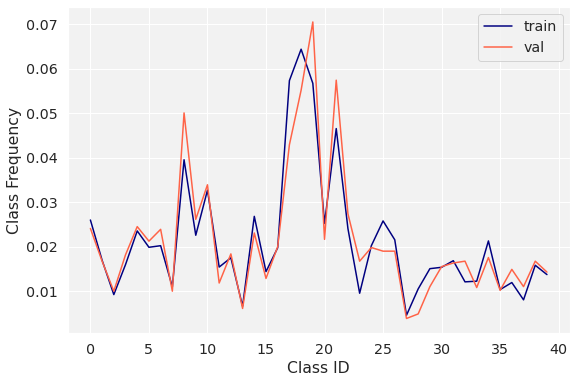

In [54]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(range(40), [class_freqs['train'][i] for i in range(40)], color='navy', label='train');
ax.plot(range(40), [class_freqs['val'][i] for i in range(40)], color='tomato', label='val');
ax.legend();
ax.set_xlabel('Class ID');
ax.set_ylabel('Class Frequency');

### Training
---

In [56]:
%ls {data_dir}

images/  labels/  train_split.txt  val_split.txt


In [102]:
data_yaml = '''
path: /kaggle/working/new_dataset/militaryaircraftdetectiondataset 
train: train_split.txt  # train images (relative to 'path') 
val: val_split.txt  # val images (relative to 'path') 

# Classes
names:
 0: A10
 1: A400M
 2: AG600
 3: AV8B
 4: B1
 5: B2
 6: B52
 7: Be200
 8: C130
 9: C17
 10: C2
 11: C5
 12: E2
 13: E7
 14: EF2000
 15: F117
 16: F14
 17: F15
 18: F16
 19: F18
 20: F22
 21: F35
 22: F4
 23: H6
 24: J10
 25: J20 
 26: JAS39
 27: JF17
 28: KC136
 29: MQ9
 30: Mig31
 31: Mirage2000
 32: P3
 33: RQ4
 34: Rafale
 35: SR71
 36: Su24
 37: Su25
 38: Su34
 39: Su57
 40: Tornado
 41: Tu160
 42: Tu22M
 43: Tu95
 44: U2
 45: US2
 46: V22
 47: Vulcan
 48: XB70
 49: YF23
'''

In [59]:
%cd /kaggle/working/yolov5

/kaggle/working/yolov5


In [103]:
with open('data/MilitaryAircraft.yaml', 'w') as f:
    f.write(data_yaml)

In [104]:
!source /kaggle/working/venv/bin/activate

In [106]:
train_script_str = '''
#!/bin/bash

BATCH_SIZE=48

RUN_NAME=train_yolov5s_low

source /kaggle/working/venv/bin/activate

python train.py \
    \
    --hyp data/hyps/hyp.scratch-low.yaml \
    \
    --img 640 \
    --batch ${BATCH_SIZE} \
    --epochs 100 \
    --data MilitaryAircraft.yaml \
    --weights yolov5s.pt \
    \
    --project runs/MilitaryAircraft \
    --exist-ok \
    --name ${RUN_NAME} 
'''

In [108]:
with open('run_train.sh', 'w') as f:
    f.write(train_script_str)

In [109]:
!chmod +x run_train.sh

In [66]:
%cd yolov5

/kaggle/working/yolov5


In [ ]:
! ./run_train.sh

train: weights=yolov5s.pt, cfg=, data=MilitaryAircraft.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=48, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/MilitaryAircraft, name=train_yolov5s_low, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-314-g60dde7f1 Python-3.8.10 torch-2.3.0+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bi